Лабораторная работа №4
=
Работу выполнили: Веэремаа А.В., Серватчук Д.С.

Дан набор данных изображений цветов, состоящий из 5 классов, разнесенных по отдельным папкам (прилагается в архиве). Сформировать обучающую и валидационную выборки из изображений исходного набора. Преобразовать исходные изображения, имеющие разную размерность матрицы, к одной размерности.
1. Построить сверточную нейронную сеть из нескольких пар слоев : Conv2D и MaxPooling , максимальной длинны допустимой приведенной размерностью входных изображений. В качестве итоговых слоев применить двухслойную по лносвязную нейронную сеть , позволяющую классифицировать на 5 классов. Пример см. в лекциях. Выполнить обучение построенной сети для решения задачи классификации изображений цветов из данного набора по 5 классам с одновременной валидацией. Выполнить при этом оценки точности обучения и валидации, а также ошибки потерь. Построить соответствующие графики.
При этом рекомендуется использовать генератор изображений, расширяющий исходный набор данных, пакетный способ обучения, регуляризацию и дропаут в
целях борьбы с переобучением. Протестировать обученную сверточную нейронную сеть на тестовой выборке.
2. Построить полносвязную нейронную сеть, позволяющую классифицировать на 5 классов исходный набор данных изображений цветов. Пример см. в лекциях. Для улучшения точности обучения и валидации использовать метод предобучения без учителя с применением автокодировщика. Выполнить обучение построенной сети для решения задачи классификации изображений цветов из данного набора по 5 классам с одновременной валидацией. Выполнить при этом оценки точности обучения и валидации, а также ошибки потерь. Построить соответствующие графики. Протестировать обученную сверточную нейронную сеть на тестовой выборке.
При этом рекомендуется использовать генератор изображений, расширяющий исходный набор данных, пакетный способ обучения, регуляризацию и дропаут
(при необходимости) в целях борьбы с переобучением
3. Сравнить полученные точности и потери для построенных сверточной и полносвязной сетей на этапах обучения и валидации.

## Конфигурация

Обозначим объект конфигурации с параметрами для нейронной сети и процесса обучения. С помощью него сможем легко и централизованно менять параметры системы.

In [4]:
CONFIG = {
    "target_width":256,
    "target_height":256,
    "ratio_train":0.6, # доля обучающей выборки
    "ratio_val":0.2, # доля валидационной выборки
    "ratio_test":0.2, # доля тестовой выборки
    "random_seed":6709834,
    "batch_size":32,
    "color_channels":3,
    "epochs_cnn":35,
    "epochs_cae":35,
    "epochs_fcn":40,
}

CONFIG["input_size"] = (CONFIG["target_width"], CONFIG["target_height"], CONFIG["color_channels"])

Подготовим структуры для статистики по моделям, будем заполнять по мере отработки моделей.

In [140]:
models_names = ["CNN", "FCN"]
models_acc = [0.0, 0.0]
models_loss = [0.0, 0.0]
models_balanced_acc = [0.0, 0.0]
models_f1_macro = [0.0, 0.0]
models_f1_weighted = [0.0, 0.0]

Импортируем используемые библиотеки или отдельные их компоненты

In [111]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, set_random_seed
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, regularizers
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Разведочный анализ данных

Для начала работы необходимо ознакомиться с набором данных. Набор в разархивированном вилде лежит в папке dataset и организован в подпапки по классам. Название подпапки будем считать названием класса. После формирования списка классов проанализируем сами изображения, в особенности их размеры, чтобы решить, к какому единому целевому размеру будем приводить всю выборку.

In [9]:
dataset_path = './dataset'
# Файлы по классам организованы в папки - берём названия папок, как названия классов
class_names = os.listdir(dataset_path)
class_count = len(class_names)
# Выведем названия классов
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Выборка состоит из 5 классов. Для работы с нейронной сетью их потребуется закодировать в числовые значения (метки). Начиная меток начинается с нуля, поэтому по существу № метки = индекс массива с названием. Для удобства номинально обозначим методы конвертации названий классов в метки и обратно.

In [11]:
def class_name_to_label(name):
    return class_names.index(name)

def class_label_to_name(label):
    return class_names[label]

Для отрисовки графика распределения обозначним чёткую ассоциацию класса и цвета. Этот момент чисто для красоты, поэтому не является универсальным решением.

In [13]:
flower_colors = {
    "daisy":"silver",
    "dandelion":"yellow",
    "roses":"red",
    "sunflowers":"gold",
    "tulips":"pink"
}

In [14]:
# Словарь изображений по классам
image_data = {}
loaded_img_counter = 0

total_width_counter = 0
total_height_counter = 0

# Массивы для формирования датафрейма Pandas
img_classes = []
img_labels = []
img_filenames = []
img_formats = []
img_widths = []
img_heights = []
img_aspect_ratios = []
img_brightness = []

for cls in class_names:
    label = class_name_to_label(cls)
    class_entry = { "name":cls, "label":label, "images":[] }
    imgfiles = os.listdir(f'{dataset_path}/{cls}/')
    for imgfile in imgfiles:
        imgpath = f'{dataset_path}/{cls}/{imgfile}'
        image_entry = { "filename":imgpath }
        try:
            with Image.open(imgpath) as image:
                #image_entry["content"] = image
                image_entry["width"] = image.size[0]
                image_entry["height"] = image.size[1]
                class_entry["images"].append(image_entry)
                # Заполнение массивов для формирования датафрейма Pandas
                img_classes.append(cls)
                img_labels.append(label)
                img_filenames.append(imgpath)
                img_formats.append(image.format)
                # Размеры, соотношение сторон
                img_widths.append(image.size[0])
                img_heights.append(image.size[1])
                img_aspect_ratios.append(image.size[0]/image.size[1])

                # Оценка средней яркости изображения
                gray_img = None
                if image.mode == 'RGB':
                    # преобразуем в grayscale для оценки яркости
                    gray_img=image.convert('L')
                elif img.mode=='L':
                    gray_img=image

                if gray_img is not None:
                    img_brightness.append(np.mean(np.array(gray_img)))
                else:
                    img_brightness.append(None)
                    
                gray_img.close()
                
                loaded_img_counter += 1
        except Exception as e:
            print(f"Ошибка чтения файла {imgfile}: {e}")
    class_entry["imgcount"] = len(class_entry["images"])
    image_data[cls] = class_entry

print(f"Загружено {loaded_img_counter} изображений.")

Загружено 3165 изображений.


Далее выведем количество изображений в каждом класс и построим график распределения.

In [16]:
for cls in class_names:
    print(f"Класс: {cls}, {image_data[cls]['imgcount']}")

Класс: daisy, 633
Класс: dandelion, 633
Класс: roses, 633
Класс: sunflowers, 633
Класс: tulips, 633


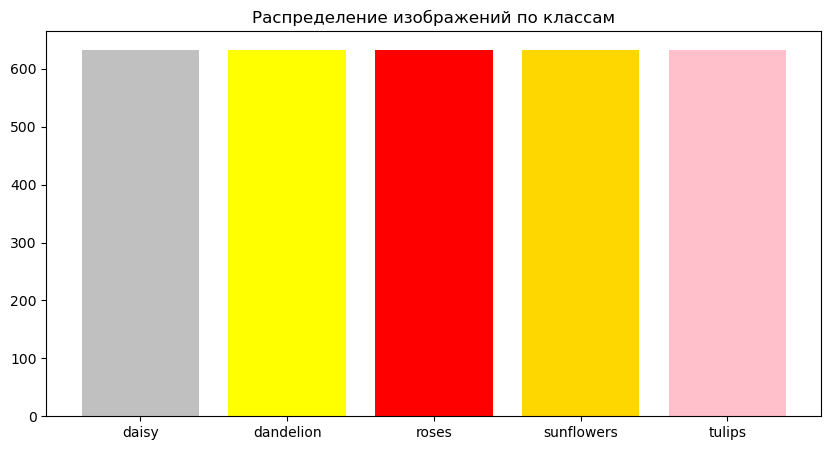

In [17]:
counts_per_class = []
plot_colors = []
for cls in class_names:
    counts_per_class.append(class_entry["imgcount"])
    plot_colors.append(flower_colors[cls])

plt.figure(figsize=(10,5))
plt.title("Распределение изображений по классам")
plt.bar(class_names, counts_per_class, color=plot_colors)
plt.show()

Набор состоит из 3165 изображений в 5 классах, при этом распределены изображения по классам поровну (по 633 изображения в каждом).
Следовательно, можно считать, что какой-либо балансировки входных или выходных данных для устранения диспропорции не потребуется (в силу её отсутствия).

Далее необходимо проанализировать размерности картинок, и решить, какому общему значению их привести. 
Для этого проанализируем размеры изображений, а также их соотношения.

Составим датафрейм Pandas с базовой информацией о изображениях.

In [21]:
img_dataframe = pd.DataFrame({
    "Класс":img_classes, 
    "Путь к файлу":img_filenames, 
    "Формат":img_formats,
    "Ширина":img_widths, 
    "Высота":img_heights, 
    "Соотношение":img_aspect_ratios,
    "Средняя яркость":img_brightness
})

img_dataframe.head()

Класс                                  Путь к файлу Формат  Ширина  Высота  \
0  daisy    ./dataset/daisy/100080576_f52e8ee070_n.jpg   JPEG     320     263   
1  daisy    ./dataset/daisy/10140303196_b88d3d6cec.jpg   JPEG     500     313   
2  daisy  ./dataset/daisy/10172379554_b296050f82_n.jpg   JPEG     320     215   
3  daisy    ./dataset/daisy/10172567486_2748826a8b.jpg   JPEG     500     333   
4  daisy  ./dataset/daisy/10172636503_21bededa75_n.jpg   JPEG     320     250   

   Соотношение  Средняя яркость  
0     1.216730       144.197600  
1     1.597444       157.306153  
2     1.488372        95.256977  
3     1.501502        59.745850  
4     1.280000        39.213125

Проанализируем форматы изображений.

In [23]:
img_dataframe["Формат"].value_counts()

Формат
JPEG    3165
Name: count, dtype: int64

Все изображения имеют формат JPEG. Следовательно, формат не будет являться фактором влияния для данной выборки.

In [25]:
pd.set_option('display.precision',3)
img_dataframe.describe()

Ширина    Высота  Соотношение  Средняя яркость
count  3165.000  3165.000     3165.000         3165.000
mean    365.492   272.585        1.325          108.086
std     117.824    52.266        0.299           34.017
min     143.000   159.000        0.596           11.653
25%     320.000   240.000        1.250           86.743
50%     320.000   240.000        1.337          107.662
75%     500.000   333.000        1.502          128.325
max    1024.000   442.000        5.476          237.323

Ширина изображения:
* Минимальная - 143 пикселя
* Средняя - 365 пикселей
* Максимальная - 1024 пикселя

Высота изображения:
* Минимальная - 159 пикселей
* Средняя - 272 пикселя
* Максимальная - 442 пикселя

Соотношение сторон:
* Минимальное - 0.596 (в ~2 раза уже)
* Среднее - 1.325
* Максимальное - 5.476 (в ~5.5 раз шире)

Средняя яркость (0-255):
* Минимальная - 11 (почти чёрное изображение)
* Средняя - 108
* Максимальная - 237 (очень яркое)

Также проанализируем распределение размерностей, что даст более чёткую картину о наиболее популярных величинах. Для этого построим гистограмму распределений размерностей.

In [28]:
size_fields = img_dataframe.loc[:,['Ширина','Высота','Соотношение', 'Средняя яркость']]

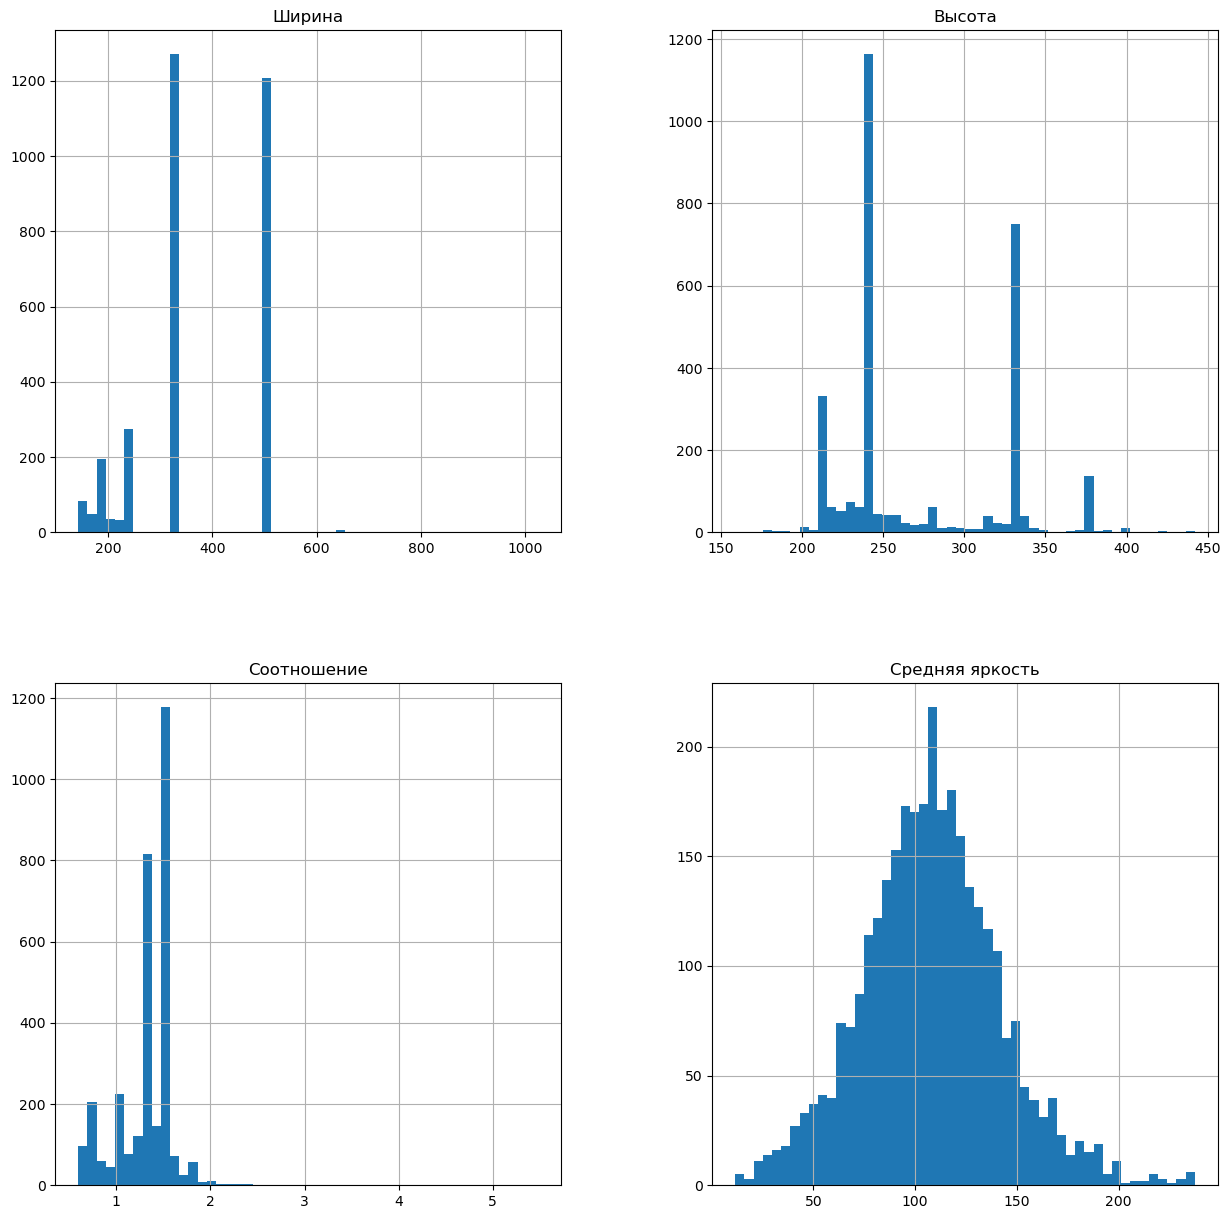

In [29]:
%matplotlib inline
size_fields.hist(bins=50, figsize=(15,15))
plt.show()

Хорошо видно, что средняя яркость изображений имеет нормальное распределение, а ширина, высота и соотношение сторон имеют по 2-3 ярко-выраженных пика.

Для более точной оценки выведем подсчёт конкретных значений размеров изображений.

In [32]:
img_dataframe["Ширина"].value_counts()

Ширина
320    1271
500    1207
240     254
180     141
159      67
       ... 
228       1
227       1
350       1
212       1
218       1
Name: count, Length: 89, dtype: int64

Порядка трети изображений имеет ширину 320, ещё треть - 500. 
По гистограмме видно, что значимое количество оставшихся изображений имеет ширине меньше 320.

In [34]:
img_dataframe["Высота"].value_counts()

Высота
240    1114
333     532
213     261
375     131
332     103
       ... 
377       1
340       1
439       1
434       1
311       1
Name: count, Length: 182, dtype: int64

Наиболее частой встречающаяся высота - 240 (около трети), высота 333 попадается примерно в два раза реже.
По гистограмме также видно, что больше значений концентрируется вокруг "пика" 240.

In [36]:
img_dataframe["Соотношение"].value_counts()

Соотношение
1.333    665
1.502    532
1.502    258
1.000    165
0.750    141
        ... 
1.276      1
1.323      1
2.336      1
1.238      1
5.476      1
Name: count, Length: 324, dtype: int64

На первый взгляд наиболее частое соотношение сторон - 1.333, т.е. 4:3 - ему соответствует 665 изображений.

Однако значение 1.502 (т.е. порядка 3:2) встречается в выборке два раза, значит, имеется два очень близких значения, разделяющихся надвое ввиду округления. В сумме на два значения приходится 790 изображений, больше. чем для 1.333.

Менее популярно значение 1.0 = 1:1 и 0.75 = 3:4.

Также необходимо учитывать наличие близких к наиболее частым значений, но их влияние точнее отражает гистограмма.

Также проанализируем количество изображений, которые значительно отклоняются от медианных значений по ширине/высоте

In [39]:
sizes_array=np.array(list(zip(img_widths,img_heights)))
size_threshold_small= (0.5*np.median(sizes_array[:,0]), 0.5*np.median(sizes_array[:,1]))
size_threshold_large= (2*np.median(sizes_array[:,0]), 2*np.median(sizes_array[:,1]))

small_images_indices=np.where((sizes_array[:,0]<size_threshold_small[0]) | (sizes_array[:,1]<size_threshold_small[1]))[0]
large_images_indices=np.where((sizes_array[:,0]>size_threshold_large[0]) | (sizes_array[:,1]>size_threshold_large[1]))[0]

print(f"Маленьких изображений (<0.5x от медианного): {len(small_images_indices)}")
print(f"Больших изображений (>2x от медианного): {len(large_images_indices)}")

Маленьких изображений (<0.5x от медианного): 77
Больших изображений (>2x от медианного): 2


Далее необходимо принять решение по целевой размерности, к которой далее будем сводить все изображения. Нужно иметь ввиду следующие соображения:
* Уменьшение изображения приведёт к частичной потере информации
* Увеличение изображения может добавить дополнительный шум в зависимости от алгоритма интерполяции
* Нарушение соотношения приводит к искажению исходной информации на изображении
* В силу специфики построения свёрточных сетей удобнее работать с величинами, являющимися степенями числа 2
* Удобнее работать с квадратными изображениями (высота = ширина)
* Чем больше размер изображения, тем больше вычислительных ресурсов потребуется на их обработку

Следовательно, необходимо подобрать целевой размер таким образом, чтобы большинство изображений претерпело минимум изменений.

На основании того, что наиболее частая ширина изображений в районе 300 или 500 пикселей, подходят величины 256 или 512.
Однако для высоты наиболее популярны размеры в районе 230 и 350 пикселей, и использование величины 512 для высоты приведёт к необходиости "растягивания" большинства изображений, поэтому для высоты больше подходит значение 256.

Следовательно, если не следовать правилу "квадратности" изображений, то логично было бы взять размер 512х256.
Для его соблюдения остановимся на целевом размере 256х256.

# 2. Подготовка наборов исходных данных

## 2.1. Подготовка изображений

Введём функцию загрузки изображения для использования в методе Dataset.map()

Помимо непосредственной загрузки исходного изображения также будем сразу приводить его к целевому размеру.

In [45]:
def load_image(filename, label, normalize = False):
    img = tf.image.decode_image(tf.io.read_file(filename), channels = CONFIG["color_channels"], expand_animations=False)
    resized = tf.image.resize(img, [CONFIG["target_width"], CONFIG["target_height"]])
    if normalize:
        resized = tf.cast(resized, tf.float32) / 255.0
    return resized, label

def normalize_image(image, label):
    image_normalized = tf.cast(image, tf.float32) / 255.0
    return image_normalized, image_normalized

Дальше обозначим функцию подготовки набора данных.

In [47]:
def prepare_dataset(files, labels, target_cae = False, shuffle = False):
    ds = tf.data.Dataset.from_tensor_slices((files, [0]*len(files) if target_cae else labels))
    if target_cae:
        ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(files) if files else 1, seed=CONFIG["random_seed"], reshuffle_each_iteration=True)
    
    ds = ds.batch(CONFIG["batch_size"])
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

## 2.2. Разделение на обучающую, тестовую и валидационную выборки

In [49]:
combined_val_test_ratio = CONFIG["ratio_test"] + CONFIG["ratio_val"]

train_labels, combi_labels, train_files, combi_files = train_test_split(
    img_labels, 
    img_filenames, 
    test_size=CONFIG["ratio_test"], 
    random_state=CONFIG["random_seed"], 
    stratify=img_classes
)

combi_val_ratio = CONFIG["ratio_val"] / combined_val_test_ratio

test_labels, val_labels, test_files, val_files, = train_test_split(combi_labels, 
    combi_files, 
    test_size=combi_val_ratio, 
    random_state=CONFIG["random_seed"], 
    stratify=combi_labels
)

Вывод распределения классов в каждой из выбранных выборок для оценки качества разбиения и балансировки данных перед обучением модели.

In [ ]:
# Функция для вывода распределения классов
def print_class_distribution(name, labels, class_names_list):
    if not labels:
        print(f"\nВыборка '{name}' пуста.")
        return
    counts = np.bincount([class_names.index(label) for label in labels], minlength=len(class_names_list))
    total_in_split = len(labels)
    print(f"\nРаспределение классов в '{name}' выборке ({total_in_split} изображений):")
    for i, class_name in enumerate(class_names):
        print(f"- {class_name}: {counts[i]} ({(counts[i]/total_in_split)*100:.1f}%)")

print_class_distribution("Обучающая", train_labels, flower_types)
print_class_distribution("Валидационная", val_labels, flower_types)
print_class_distribution("Тестовая", test_labels, flower_types)

# 3. Построение, обучение и проверка свёрточной нейронной сети (CNN)

Подготовим наборы данных (уже с изображенниями) на основании выборки в определённых в конфигурации соотношениях.

In [52]:
train_ds_clf = prepare_dataset(train_files, train_labels, shuffle=True)
val_ds_clf = prepare_dataset(val_files, val_labels)
test_ds_clf = prepare_dataset(test_files, test_labels)

Для повторимости результата зададим значение seed для генераторов случайных чисел.

In [54]:
set_random_seed(CONFIG["random_seed"])

Создадим модель сверточной нейронной сети (CNN) для задачи классификации изображений.
В модели обозначим слои для аугментации данных (зеркалирование, вращение, масштабирование, смещение яркости и контраста).
Обозначим слой масштабирования для нормализации, свёрточные слои и полносвязный слой для регуляризации.

In [56]:
def build_advanced_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # Входной слой
    model.add(tf.keras.layers.Input(shape=input_shape))
    
    # Слои аугментации данных (встроенные слои)
    model.add(tf.keras.layers.RandomFlip("horizontal"))
    model.add(tf.keras.layers.RandomRotation(0.1))
    model.add(tf.keras.layers.RandomZoom(0.2))
    model.add(tf.keras.layers.RandomBrightness(factor=0.1))
    model.add(tf.keras.layers.RandomContrast(factor=0.1))
    
    # Нормализация изображений
    model.add(tf.keras.layers.Rescaling(1./255))
    
    # Архитектура сверточных слоев с BatchNormalization
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    # Добавляем еще один сверточный блок для увеличения глубины сети
    model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    # Еще один сверточный слой для повышения сложности модели
    model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    # Глобальный пуллинг
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    
    # Полносвязный слой с Dropout для регуляризации
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # Выходной слой
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
    
    return model

# Создаем модель
cnn_model = build_advanced_cnn_model(input_shape=CONFIG["input_size"], num_classes=class_count)

# Компилируем модель
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Выведем характеристику слоёв полученной модели.

In [87]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 256, 256, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             

 Total params: 1,048,517 (4.00 MB)

 Trainable params: 1,047,045 (3.99 MB)

 Non-trainable params: 1,472 (5.75 KB)

Объявим коллбеки для раннего останова обучения (на основании потерь относительно валидационной выборки), а также для сохранения лучшей модели.

In [90]:
# Объявление коллбеков
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True, 
    verbose=1
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_cnn_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1
)

Далее произведём обучение модели.

In [93]:
history_cnn = cnn_model.fit(
    train_ds_clf,
    epochs=CONFIG["epochs_cnn"],
    validation_data=val_ds_clf,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.4187 - loss: 2.3349
Epoch 1: val_accuracy improved from -inf to 0.19874, saving model to best_cnn_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 716ms/step - accuracy: 0.4195 - loss: 2.3255 - val_accuracy: 0.1987 - val_loss: 2.7712
Epoch 2/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.5752 - loss: 1.0689
Epoch 2: val_accuracy did not improve from 0.19874
80/80 ━━━━━━━━━━━━━━━━━━━━ 56s 703ms/step - accuracy: 0.5754 - loss: 1.0684 - val_accuracy: 0.1987 - val_loss: 3.2668
Epoch 3/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6014 - loss: 0.9928
Epoch 3: val_accuracy improved from 0.19874 to 0.20505, saving model to best_cnn_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 55s 690ms/step - accuracy: 0.6016 - loss: 0.9923 - val_accuracy: 0.2050 - val_loss: 3.2254
Epoch 4/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.6155 - loss: 0.9698
Epoch 4: val_accuracy improved from 0.20505 to 0.27129, saving model

Возьмём историю изменения 4 параметров точности и потерь (обучение и валидация)

In [101]:
# Графики обучения (точность и потери)
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

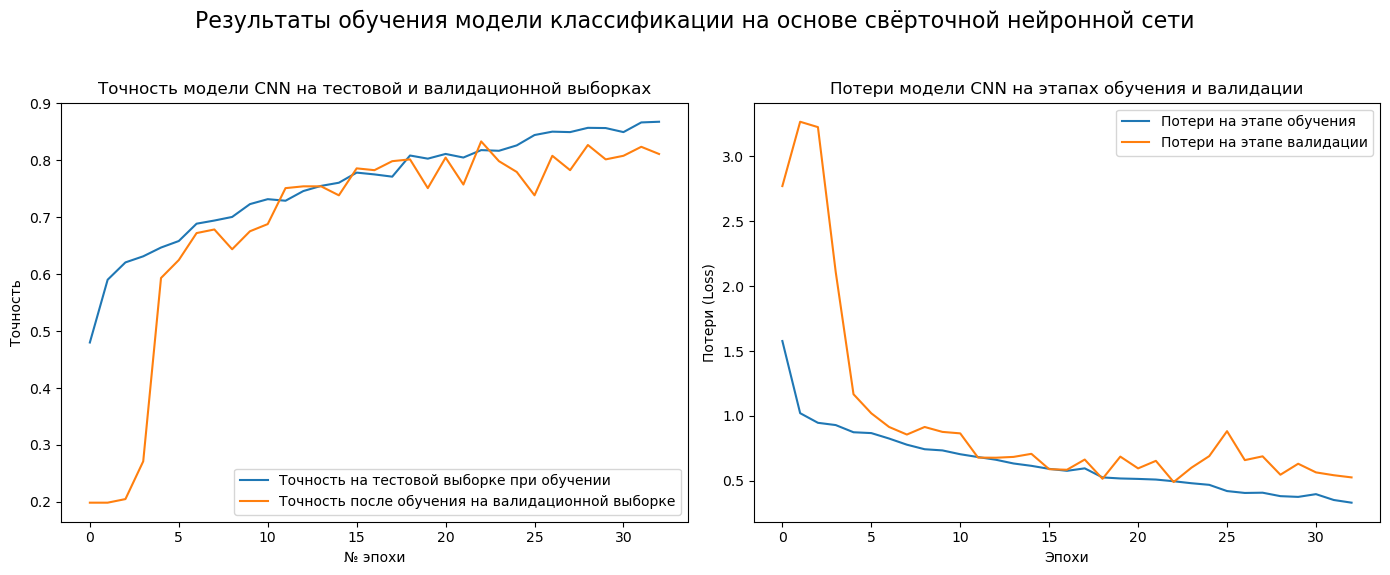

In [103]:
# Фактическое количество эпох (если сработал EarlyStopping)
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тестовой выборке при обучении')
plt.plot(epochs_range, val_acc, label='Точность после обучения на валидационной выборке')
plt.legend(loc='lower right')
plt.title('Точность модели CNN на тестовой и валидационной выборках')
plt.xlabel('№ эпохи')
plt.ylabel('Точность')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на этапе обучения')
plt.plot(epochs_range, val_loss, label='Потери на этапе валидации')
plt.legend(loc='upper right')
plt.title('Потери модели CNN на этапах обучения и валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери (Loss)')

plt.suptitle('Результаты обучения модели классификации на основе свёрточной нейронной сети', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Немного места для suptitle
plt.show()

In [207]:
# Загрузка лучшей модели
best_cnn_model = models.load_model('best_cnn_model.keras')

test_loss_cnn, test_acc_cnn = best_cnn_model.evaluate(test_ds_clf, verbose=0)

y_true_cnn = []
y_pred_probs = []

for images_batch, labels_batch in test_ds_clf:
    y_true_cnn.extend(labels_batch.numpy())
    preds_batch = best_cnn_model.predict_on_batch(images_batch)
    y_pred_probs.extend(preds_batch)

y_true_cnn = np.array(y_true_cnn)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes_cnn = np.argmax(y_pred_probs, axis=1)

idx_cnn = models_names.index("CNN")
models_acc[idx_cnn] = accuracy_score(y_true_cnn, y_pred_classes_cnn)
models_loss[idx_cnn] = test_loss_cnn
models_balanced_acc[idx_cnn] = balanced_accuracy_score(y_true_cnn, y_pred_classes_cnn)
models_f1_macro[idx_cnn] = f1_score(y_true_cnn, y_pred_classes_cnn, average='macro')
models_f1_weighted[idx_cnn] = f1_score(y_true_cnn, y_pred_classes_cnn, average='weighted')

print(f"Accuracy: {models_acc[idx_cnn]:.4f}")
print(f"Loss: {models_loss[idx_cnn]:.4f}")
print(f"Balanced Accuracy: {models_balanced_acc[idx_cnn]:.4f}")
print(f"F1 Score (macro): {models_f1_macro[idx_cnn]:.4f}")
print(f"F1 Score (weighted): {models_f1_weighted[idx_cnn]:.4f}")

Accuracy: 0.8038
Loss: 0.4941
Balanced Accuracy: 0.8040
F1 Score (macro): 0.8070
F1 Score (weighted): 0.8069


Отчёт о классификации

In [120]:
print(classification_report(y_true_cnn, y_pred_classes_cnn, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       daisy     0.9153    0.8571    0.8852        63
   dandelion     0.9388    0.7302    0.8214        63
       roses     0.7619    0.7500    0.7559        64
  sunflowers     0.8438    0.8571    0.8504        63
      tulips     0.6420    0.8254    0.7222        63

    accuracy                         0.8038       316
   macro avg     0.8203    0.8040    0.8070       316
weighted avg     0.8201    0.8038    0.8069       316



Отобразим предсказания для набора изображений

In [187]:
def predict_plot(model_name, prediction_model):
    plt.figure(figsize=(12, 12))
    for images, labels in test_ds_clf.take(1):
        predictions = prediction_model.predict(images)
        for i in range(min(25, len(images))):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8")) 
            predicted_class_idx = np.argmax(predictions_fcn[i])
            predicted_class = class_names[predicted_class_idx]
            true_class = class_names[labels[i].numpy()]
            confidence = np.max(predictions[i]) * 100
            title_color = 'green' if predicted_class == true_class else 'red'
            plt.title(f"Предсказание: {predicted_class} ({confidence:.1f}%)\nИстина: {true_class}", color=title_color, fontsize=9)
            plt.axis("off")
    plt.suptitle(f"Примеры предсказаний {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


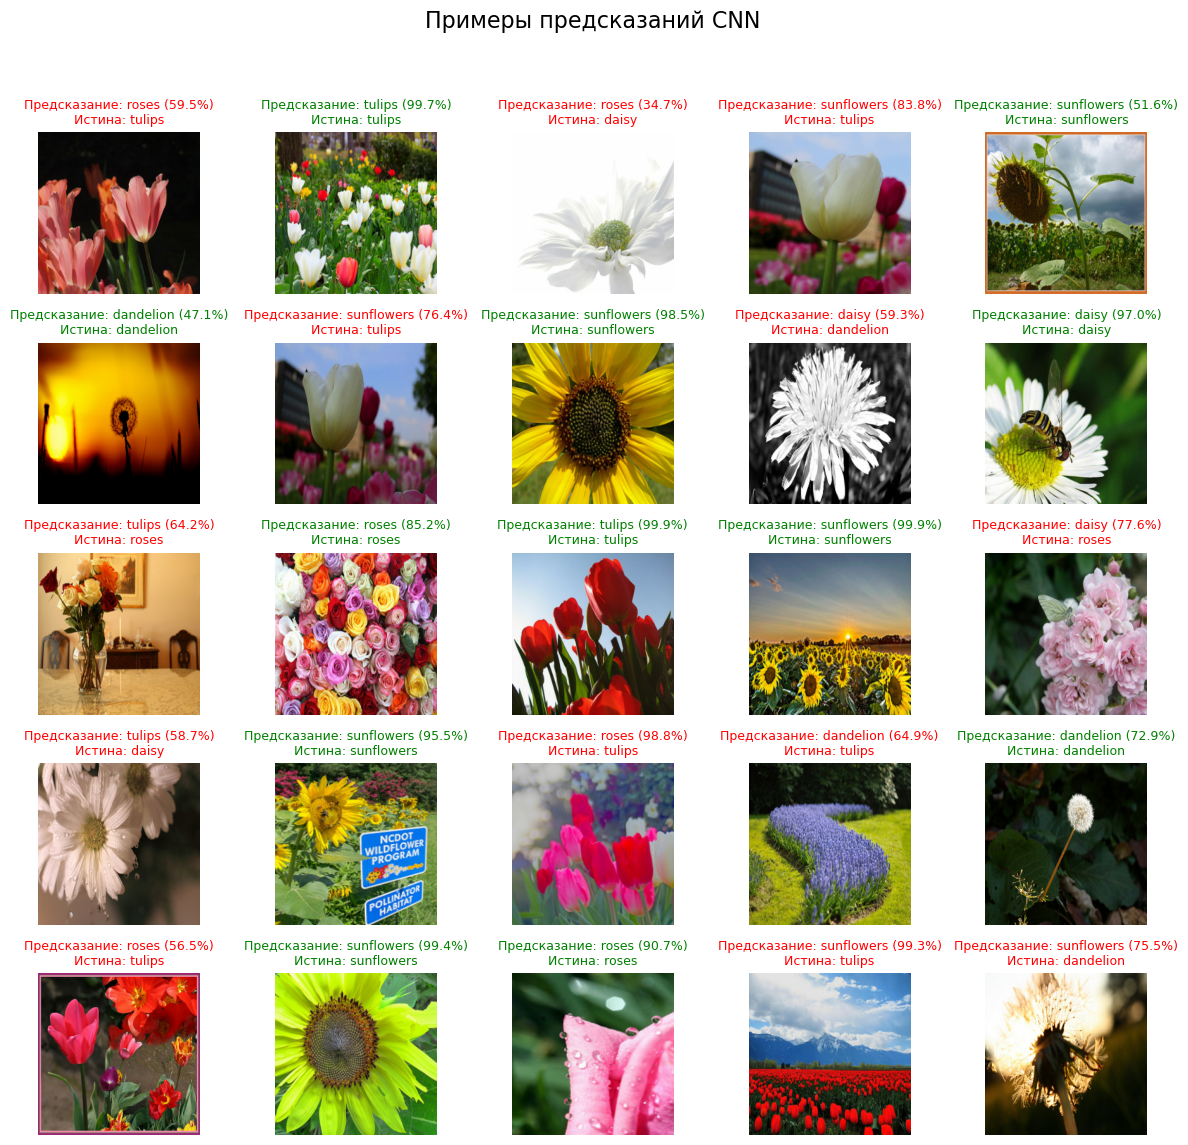

In [189]:
predict_plot('CNN',best_cnn_model)

# 4. Построение, обучение и проверка полносвязной нейронной сети

Подготовим набор данных для полносвязной нейронной сети. В данном случае значения каналов будем нормализовывать с помощью средств Dataset.

In [124]:
train_ds_cae = prepare_dataset(train_files, train_labels, True)
val_ds_cae = prepare_dataset(val_files, val_labels, True)
test_ds_cae = prepare_dataset(test_files, test_labels, True)

In [126]:
def build_cae_model(input_shape_cae):
    # Энкодер
    encoder_cae = models.Sequential([
        layers.Input(shape=input_shape_cae, name="cae_encoder_input"),
        #layers.Rescaling(1./255),
        #layers.Reshape(CONFIG["input_size"], input_shape=[CONFIG["target_width"], CONFIG["target_width"]]),
        layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(128, kernel_size=3, padding='same', activation='selu'),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(256, kernel_size=3, padding='same', activation='selu'),
        layers.MaxPool2D((2, 2), name="cae_encoded_output"),
    ], name="cae_encoder")

    # Декодер
    decoder_cae = models.Sequential([
        layers.Input(shape=encoder_cae.output_shape[1:], name="cae_decoder_input"),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='selu'),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='selu'),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='selu'),
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='selu'),
        layers.Conv2D(CONFIG["color_channels"], (3, 3), activation='sigmoid', padding='same', name="cae_decoded_output"),
    ], name="cae_decoder")

    # Автокодировщик
    autoencoder_input = Input(shape=input_shape_cae, name="cae_full_input")
    encoded_img = encoder_cae(autoencoder_input)
    decoded_img = decoder_cae(encoded_img)
    cae_model_full = Model(autoencoder_input, decoded_img, name="convolutional_autoencoder")
    
    return cae_model_full, encoder_cae, decoder_cae

In [128]:
cae_model, encoder_cae, decoder_cae = build_cae_model(CONFIG["input_size"])
cae_model.compile(optimizer='adam', loss='mse')

In [130]:
encoder_cae.summary()

Model: "cae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cae_encoded_output              │ (None, 16, 16, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,416 (1.48 MB)

 Trainable params: 388,416 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
decoder_cae.summary()

Model: "cae_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 32, 32, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cae_decoded_output (Conv2D)     │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 978,243 (3.73 MB)

 Trainable params: 978,243 (3.73 MB)

 Non-trainable params: 0 (0.00 B)

In [134]:
cae_model.summary()

Model: "convolutional_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cae_full_input (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cae_encoder (Sequential)        │ (None, 16, 16, 256)    │       388,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cae_decoder (Sequential)        │ (None, 256, 256, 3)    │       978,243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,659 (5.21 MB)

 Trainable params: 1,366,659 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
# Обучение CAE
early_stopping_cae = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint_cae = ModelCheckpoint('best_cae_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history_cae = cae_model.fit(
    train_ds_cae,
    epochs=CONFIG["epochs_cae"],
    validation_data=val_ds_cae,
    verbose=1,
    callbacks=[early_stopping_cae, model_checkpoint_cae]
)

Epoch 1/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - loss: 0.0526
Epoch 1: val_loss improved from inf to 0.01361, saving model to best_cae_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 662ms/step - loss: 0.0523 - val_loss: 0.0136
Epoch 2/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - loss: 0.0130
Epoch 2: val_loss improved from 0.01361 to 0.01059, saving model to best_cae_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 52s 654ms/step - loss: 0.0130 - val_loss: 0.0106
Epoch 3/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 0.0109
Epoch 3: val_loss improved from 0.01059 to 0.00901, saving model to best_cae_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 52s 656ms/step - loss: 0.0109 - val_loss: 0.0090
Epoch 4/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - loss: 0.0097
Epoch 4: val_loss improved from 0.00901 to 0.00889, saving model to best_cae_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 663ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 5/35
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - loss: 0.0087
Epoch 5: 

In [143]:
best_cae_model_loaded = models.load_model('best_cae_model.keras')
encoder_cae = best_cae_model_loaded.get_layer('cae_encoder')

In [145]:
# Визуализация реконструкций CAE
def plot_cae_reconstructions(model_to_test, dataset_to_test, n=5):
    plt.figure(figsize=(12, 5)) 
    for images_in, images_out_target in dataset_to_test.take(1): 
        reconstructed_images = model_to_test.predict(images_in)
        for i in range(min(n, CONFIG["batch_size"], len(images_in))): 
            # Оригинальное изображение
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(images_in[i].numpy())
            plt.title("Оригинал")
            plt.axis("off")

            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed_images[i]) 
            plt.title("Реконструкция")
            plt.axis("off")
    plt.suptitle("Реконструкции Сверточного Автокодировщика (CAE)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


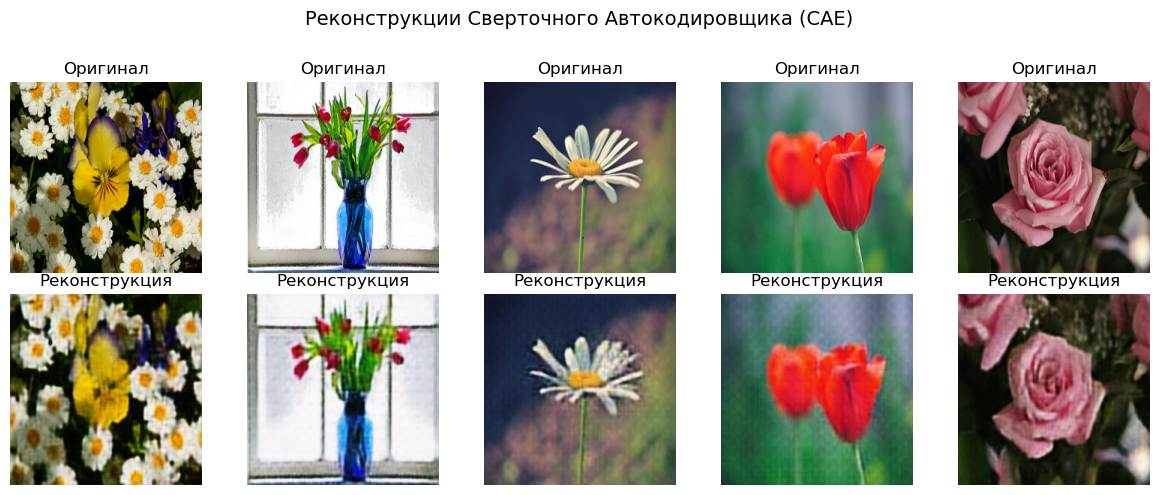

In [147]:
data_for_cae_viz = val_ds_cae if tf.data.experimental.cardinality(val_ds_cae).numpy() > 0 else train_ds_cae
plot_cae_reconstructions(cae_model, data_for_cae_viz)

Построим полносвязную сеть (FCN) для классификации с предобученным энкодером

In [222]:
# Предотвращаем дальнейшее обучение автоэнкодера обучение
encoder_cae.trainable = False

# Аналогично свёрточной модели произведём аугментацию входных изображений
fcn_preprocessor = models.Sequential([
    layers.Input(shape=CONFIG["input_size"]),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(factor=0.1),
    layers.RandomContrast(factor=0.1),
    layers.Rescaling(1./255),
], name="fcn_data_preprocessing")

# Сам классификатор
fcn = models.Sequential([
    layers.Input(shape=encoder_cae.output_shape[1:]), # Вход - выход энкодера
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
], name="fcn_classification_head")

print("\nАрхитектура FCN classification head:")
fcn.summary()


Архитектура FCN classification head:


Model: "fcn_classification_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,549 (64.13 MB)

 Trainable params: 16,811,781 (64.13 MB)

 Non-trainable params: 768 (3.00 KB)

In [224]:
# Собираем полную модель для классификации
fcn_full_classifier = models.Sequential([
    fcn_preprocessor,
    encoder_cae,
    fcn
], name="FCN_with_pretrained_CAE_encoder")

fcn_full_classifier.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
fcn_full_classifier.summary()

Model: "FCN_with_pretrained_CAE_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fcn_data_preprocessing          │ (None, 256, 256, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cae_encoder (Sequential)        │ (None, 16, 16, 256)    │       388,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fcn_classification_head         │ (None, 5)              │    16,812,549 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,200,965 (65.62 MB)

 Trainable params: 16,811,781 (64.13 MB)

 Non-trainable params: 389,184 (1.48 MB)

In [154]:
# Обучение FCN-классификатора
early_stopping_fcn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint_fcn = ModelCheckpoint('best_fcn_classifier_pretrained.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

history_fcn = fcn_full_classifier.fit(
    train_ds_clf,
    epochs=CONFIG["epochs_fcn"],
    validation_data=val_ds_clf,
    verbose=1,
    callbacks=[early_stopping_fcn, model_checkpoint_fcn]
)

Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.3001 - loss: 3.2353
Epoch 1: val_accuracy improved from -inf to 0.52997, saving model to best_fcn_classifier_pretrained.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.3005 - loss: 3.2346 - val_accuracy: 0.5300 - val_loss: 2.6224
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3776 - loss: 3.0489
Epoch 2: val_accuracy improved from 0.52997 to 0.54890, saving model to best_fcn_classifier_pretrained.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.3779 - loss: 3.0478 - val_accuracy: 0.5489 - val_loss: 2.3669
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4077 - loss: 2.8613
Epoch 3: val_accuracy improved from 0.54890 to 0.55205, saving model to best_fcn_classifier_pretrained.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 0.4080 - loss: 2.8601 - val_accuracy: 0.5521 - val_loss: 2.2705
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 

In [156]:
# Загрузка лучшей модели FCN
if os.path.exists('best_fcn_classifier_pretrained.keras'):
    best_fcn_model_loaded = models.load_model('best_fcn_classifier_pretrained.keras')
else:
    best_fcn_model_loaded = fcn_full_classifier

In [158]:
# Оценка FCN на тестовой выборке
print("\nОценка FCN-классификатора (с предобучением) на тестовой выборке:")
test_loss_fcn, test_acc_fcn = best_fcn_model_loaded.evaluate(test_ds_clf, verbose=0)
print(f'Точность FCN (с предобучением) на тестовой выборке: {test_acc_fcn*100:.2f}%')
print(f'Потери FCN (с предобучением) на тестовой выборке: {test_loss_fcn:.4f}')


Оценка FCN-классификатора (с предобучением) на тестовой выборке:
Точность FCN (с предобучением) на тестовой выборке: 61.71%
Потери FCN (с предобучением) на тестовой выборке: 1.8538


Метрики классификации на тестовой выборке (FCN с предобучением)

In [163]:
y_true_fcn = []
y_pred_probs_fcn = []
for images_batch, labels_batch in test_ds_clf:
    y_true_fcn.extend(labels_batch.numpy())
    preds_batch = best_fcn_model_loaded.predict_on_batch(images_batch)
    y_pred_probs_fcn.extend(preds_batch)

y_true_fcn = np.array(y_true_fcn)
y_pred_probs_fcn = np.array(y_pred_probs_fcn)
y_pred_classes_fcn = np.argmax(y_pred_probs_fcn, axis=1)

idx_cnn = models_names.index("FCN")
models_acc[idx_cnn] = accuracy_score(y_true_fcn, y_pred_classes_fcn)
models_balanced_acc[idx_cnn] = balanced_accuracy_score(y_true_fcn, y_pred_classes_fcn)
models_f1_macro[idx_cnn] = f1_score(y_true_fcn, y_pred_classes_fcn, average='macro')
models_f1_weighted[idx_cnn] = f1_score(y_true_fcn, y_pred_classes_fcn, average='weighted')

print(f"Accuracy: {models_acc[idx_cnn]:.4f}")
print(f"Balanced Accuracy: {models_balanced_acc[idx_cnn]:.4f}")
print(f"F1 Score (macro): {models_f1_macro[idx_cnn]:.4f}")
print(f"F1 Score (weighted): {models_f1_weighted[idx_cnn]:.4f}")

Accuracy: 0.6171
Balanced Accuracy: 0.6170
F1 Score (macro): 0.6130
F1 Score (weighted): 0.6130


Выведем отчёт о классификации для полносвязной сети

In [166]:
print(classification_report(y_true_fcn, y_pred_classes_fcn, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       daisy     0.6610    0.6190    0.6393        63
   dandelion     0.7500    0.5238    0.6168        63
       roses     0.5385    0.6562    0.5915        64
  sunflowers     0.5714    0.8254    0.6753        63
      tulips     0.6591    0.4603    0.5421        63

    accuracy                         0.6171       316
   macro avg     0.6360    0.6170    0.6130       316
weighted avg     0.6357    0.6171    0.6130       316



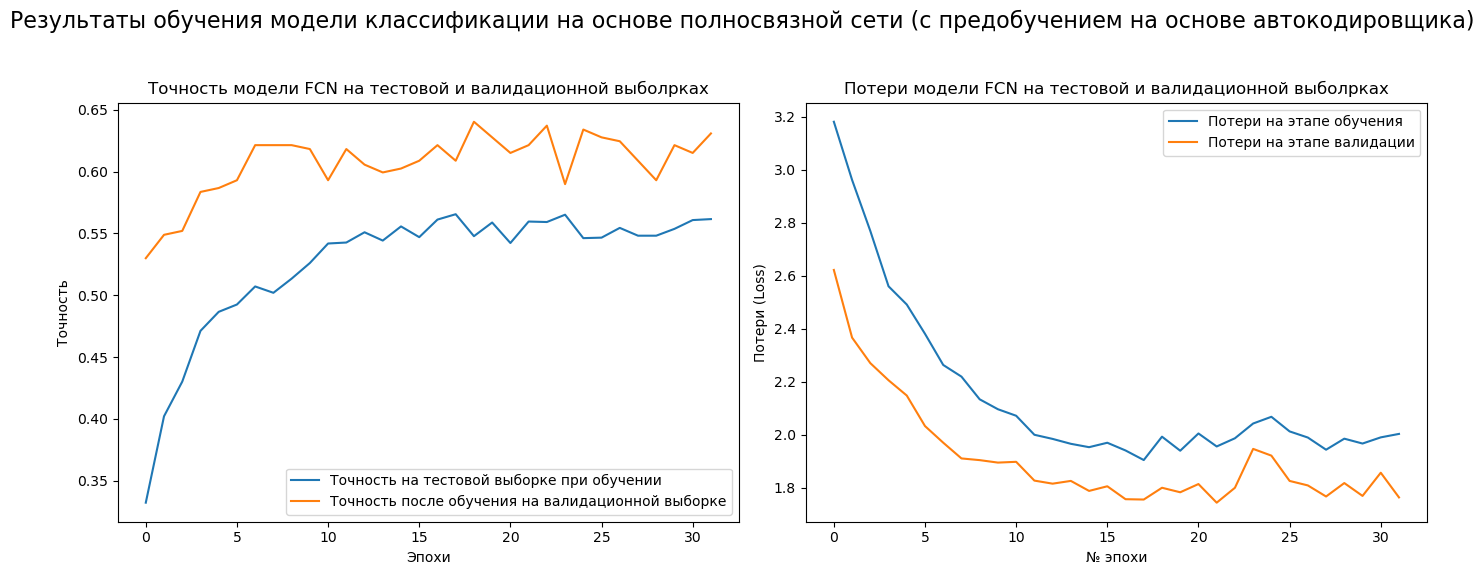

In [195]:
acc_fcn = history_fcn.history['accuracy']
val_acc_fcn = history_fcn.history['val_accuracy']
loss_fcn = history_fcn.history['loss']
epochs_range_fcn = range(len(acc_fcn))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_fcn, acc_fcn, label='Точность на тестовой выборке при обучении')
plt.plot(epochs_range_fcn, val_acc_fcn, label='Точность после обучения на валидационной выборке')
plt.legend(loc='lower right'); plt.title('Точность модели FCN на тестовой и валидационной выболрках'); plt.xlabel('Эпохи'); plt.ylabel('Точность')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_fcn, loss_fcn, label='Потери на этапе обучения')
if 'val_loss' in history_fcn.history:
    val_loss_fcn = history_fcn.history['val_loss']
    plt.plot(epochs_range_fcn, val_loss_fcn, label='Потери на этапе валидации')
plt.legend(loc='upper right'); plt.title('Потери модели FCN на тестовой и валидационной выболрках'); plt.xlabel('№ эпохи'); plt.ylabel('Потери (Loss)')
plt.suptitle('Результаты обучения модели классификации на основе полносвязной сети (с предобучением на основе автокодировщика)', fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


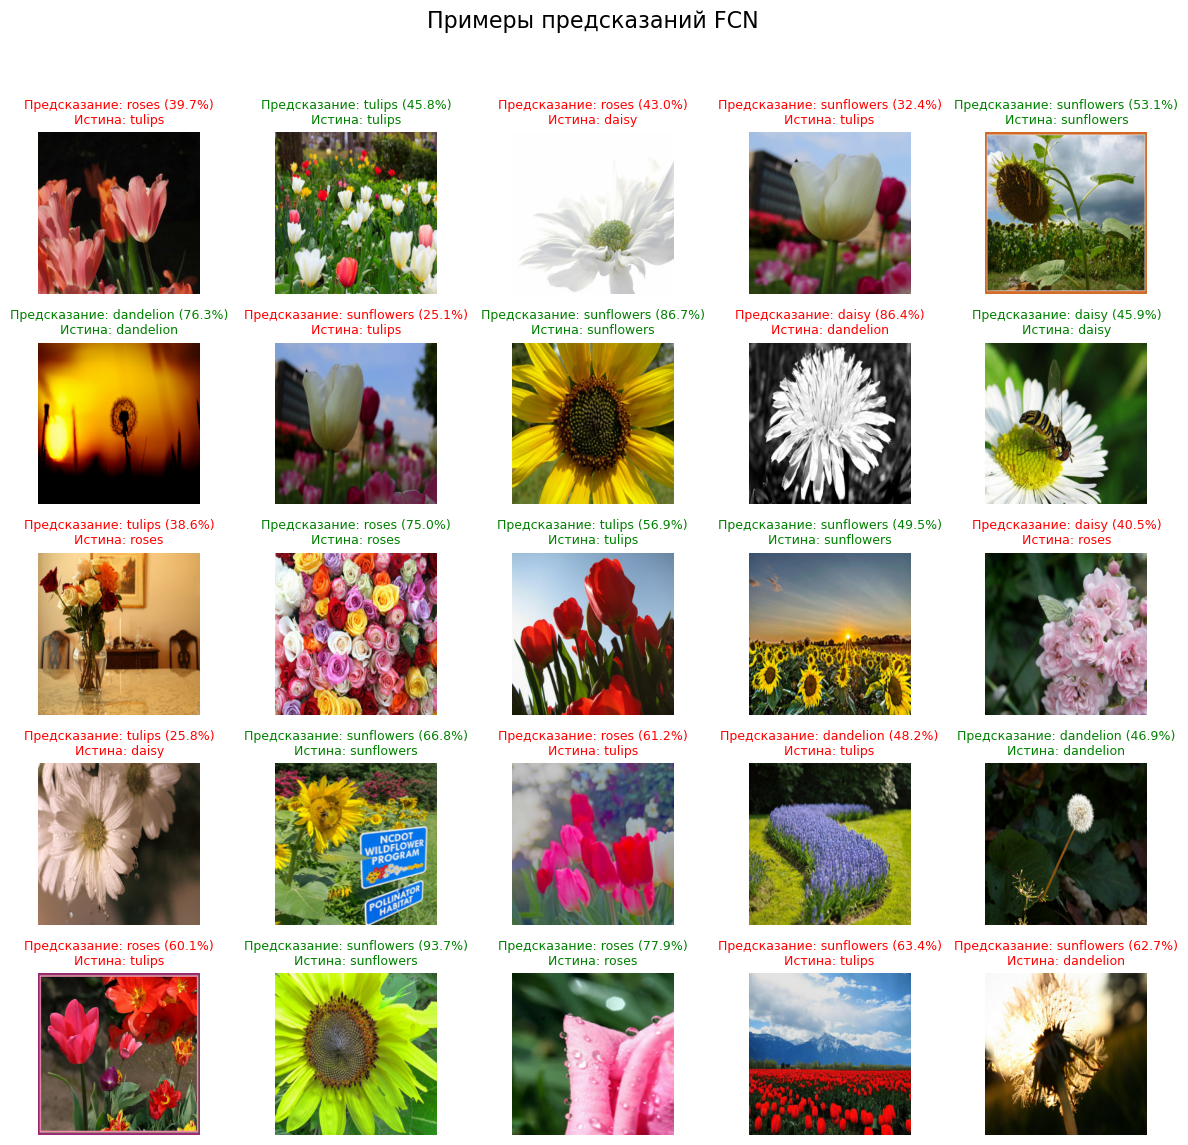

In [197]:
predict_plot('FCN', best_fcn_model_loaded)

# 5. Сравнение моделей

In [212]:
pd.set_option('display.precision',4)
stats_df = pd.DataFrame({
    'Модель':models_names,
    'Точность':models_acc,
    'Потери':models_loss,
    'Сбалансированная точность':models_balanced_acc, 
    'F1 (macro)':models_f1_macro, 
    'F1 (weighted)':models_f1_weighted}
)

stats_df

Модель  Точность  Потери  Сбалансированная точность  F1 (macro)  \
0    CNN    0.8038  0.4941                      0.804       0.807   
1    FCN    0.6171  0.0000                      0.617       0.613   

   F1 (weighted)  
0         0.8069  
1         0.6130

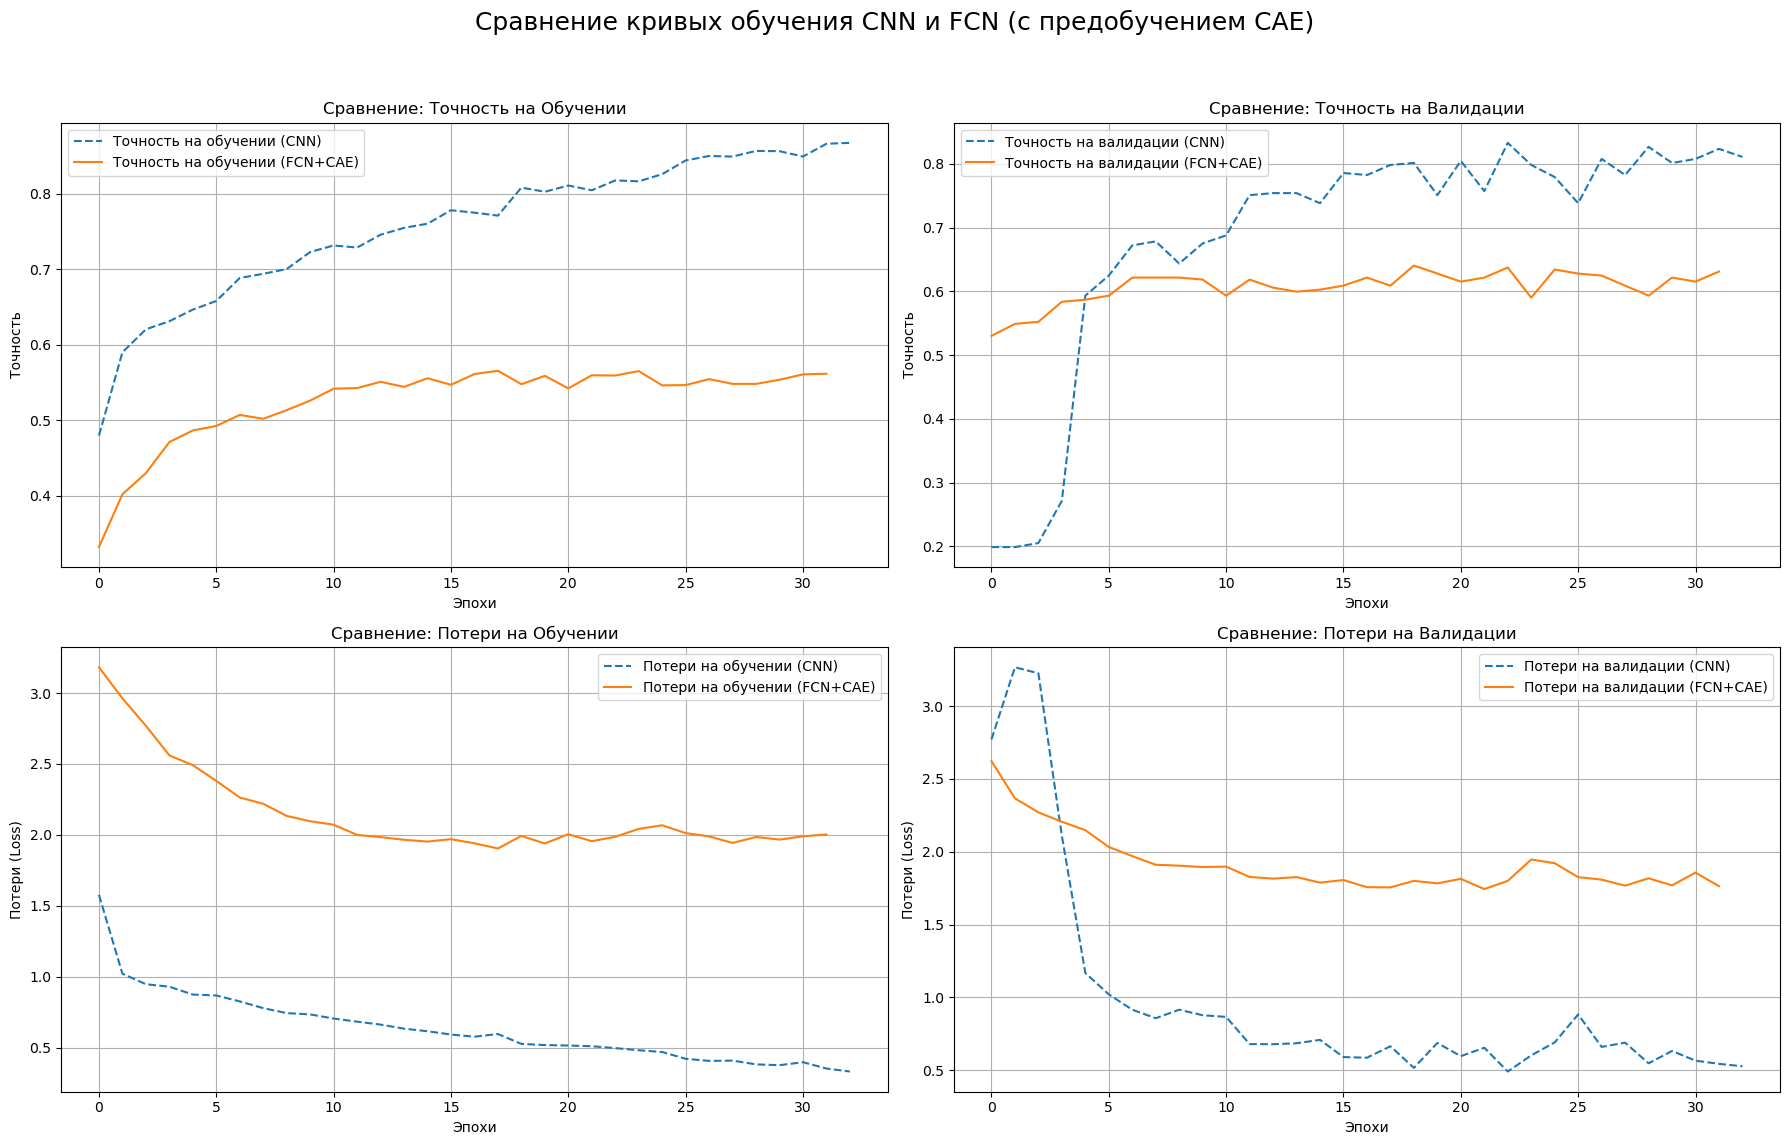

In [214]:
# Сравнение графиков обучения
plt.figure(figsize=(18, 12))

# График точности на обучении
plt.subplot(2, 2, 1)
if 'history_cnn' in locals() and history_cnn:
    epochs_range_cnn_plot = range(len(history_cnn.history['accuracy']))
    plt.plot(epochs_range_cnn_plot, history_cnn.history['accuracy'], label='Точность на обучении (CNN)', linestyle='--')
if 'history_fcn' in locals() and history_fcn:
    epochs_range_fcn_plot = range(len(history_fcn.history['accuracy']))
    plt.plot(epochs_range_fcn_plot, history_fcn.history['accuracy'], label='Точность на обучении (FCN+CAE)')
plt.title('Сравнение: Точность на Обучении')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# График точности на валидации
plt.subplot(2, 2, 2)
if 'history_cnn' in locals() and history_cnn and 'val_accuracy' in history_cnn.history:
    epochs_range_cnn_plot = range(len(history_cnn.history['val_accuracy']))
    plt.plot(epochs_range_cnn_plot, history_cnn.history['val_accuracy'], label='Точность на валидации (CNN)', linestyle='--')
if 'history_fcn' in locals() and history_fcn and 'val_accuracy' in history_fcn.history:
    epochs_range_fcn_plot = range(len(history_fcn.history['val_accuracy']))
    plt.plot(epochs_range_fcn_plot, history_fcn.history['val_accuracy'], label='Точность на валидации (FCN+CAE)')
plt.title('Сравнение: Точность на Валидации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# График потерь на обучении
plt.subplot(2, 2, 3)
if 'history_cnn' in locals() and history_cnn:
    epochs_range_cnn_plot = range(len(history_cnn.history['loss']))
    plt.plot(epochs_range_cnn_plot, history_cnn.history['loss'], label='Потери на обучении (CNN)', linestyle='--')
if 'history_fcn' in locals() and history_fcn:
    epochs_range_fcn_plot = range(len(history_fcn.history['loss']))
    plt.plot(epochs_range_fcn_plot, history_fcn.history['loss'], label='Потери на обучении (FCN+CAE)')
plt.title('Сравнение: Потери на Обучении')
plt.xlabel('Эпохи')
plt.ylabel('Потери (Loss)')
plt.legend()
plt.grid(True)

# График потерь на валидации
plt.subplot(2, 2, 4)
if 'history_cnn' in locals() and history_cnn and 'val_loss' in history_cnn.history:
    epochs_range_cnn_plot = range(len(history_cnn.history['val_loss']))
    plt.plot(epochs_range_cnn_plot, history_cnn.history['val_loss'], label='Потери на валидации (CNN)', linestyle='--')
if 'history_fcn' in locals() and history_fcn and 'val_loss' in history_fcn.history:
    epochs_range_fcn_plot = range(len(history_fcn.history['val_loss']))
    plt.plot(epochs_range_fcn_plot, history_fcn.history['val_loss'], label='Потери на валидации (FCN+CAE)')
plt.title('Сравнение: Потери на Валидации')
plt.xlabel('Эпохи')
plt.ylabel('Потери (Loss)')
plt.legend()
plt.grid(True)

plt.suptitle('Сравнение кривых обучения CNN и FCN (с предобучением CAE)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Оставляем место для suptitle
plt.show()

# Выводы
В рамках лабораторной работы решалась задача классификации изображений на основе нейросетевых моделей. Произведён разведочный и предктивный анализ выборки. Для работы с нейросетевыми модулями потребовалось привести размеры изображений к единому виду.

В ходе разведочного анализа проанализирован общий характер выборки. Выборка размечена по 5 классам и состояит из 3165 изображений, распределённых по классам поровну. Проанализировано распределение размеров, соотношения, и средней яркости изображений. По результатам анализа решено взять целевой размер 256х256 пикселей.

В рамках лабораторной работы построены следующие модели для классификации изображений:
* Модель на основе свёрточной нейронной сети (CNN)
* Модель на основе полносвязной нейронной сети (FCN) с предобучением с помощью автокодировщика (CAN)

Точность лучшей модели на основе CNN составила 80.38%, точность лучшей модели на основе FCN с автокодировщиком составила 61.71%.
Таким образом, среди построенных моделей модель на базе свёрточной нейронной сети дала значительно лучший результат при решении задачи классификации.